# VGG8B - FashionMNIST

In [1]:
import numpy as np
import cupy as cp
import pathlib
import pickle
import csv
import sys

In [2]:
sys.path.append(str(pathlib.Path('../../').resolve()))

In [3]:
from lib.experiments import train_test_experiment, build_CNN, build_augmentation_pipeline
from lib.utils.enums import NonLinearity, Initialization, Dataset, OptimizerName
from lib.utils.data import load_integer_dataset

## Experiments config

In [4]:
architecture = [
    ('Conv2d', 128, 3, 1, 1),
    ('Conv2d', 256, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 256, 3, 1, 1),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
]
num_fc_layers = 2
num_fc_hidden = [1024]

In [5]:
dataset_config = dict(
    dataset=Dataset.FASHION_MNIST.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    data_augmentation=True,
    normalize=True,
)

In [6]:
network_config = dict(
    architecture=architecture,
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    pred_decoder_dim=4096,
    fe_dropout_rate=0.0,
    fc_dropout_rate=0.1,
    seed=42,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    pooling_type='max',
    bias=False,
    debug=False,
)

In [7]:
training_config = dict(
    batch_size=64,
    num_epochs=150,
    lr_inv=512,
    lr_amp_factor=640,
    fwd_decay_inv=28_000,
    subnet_decay_inv=3500,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [8]:
config = dataset_config | network_config | training_config

## Run the configuration

Training on 60000 samples
Data normalized. New statistics:
-  Min: -45
-  Max: 114
- Mean: 0
-  Std: 56

Moved data to device: <CUDA Device 0>
Train set:  (60000, 1, 28, 28), (60000, 10)
Test set:   (10000, 1, 28, 28), (10000, 10)
Data types: (int8, int8)


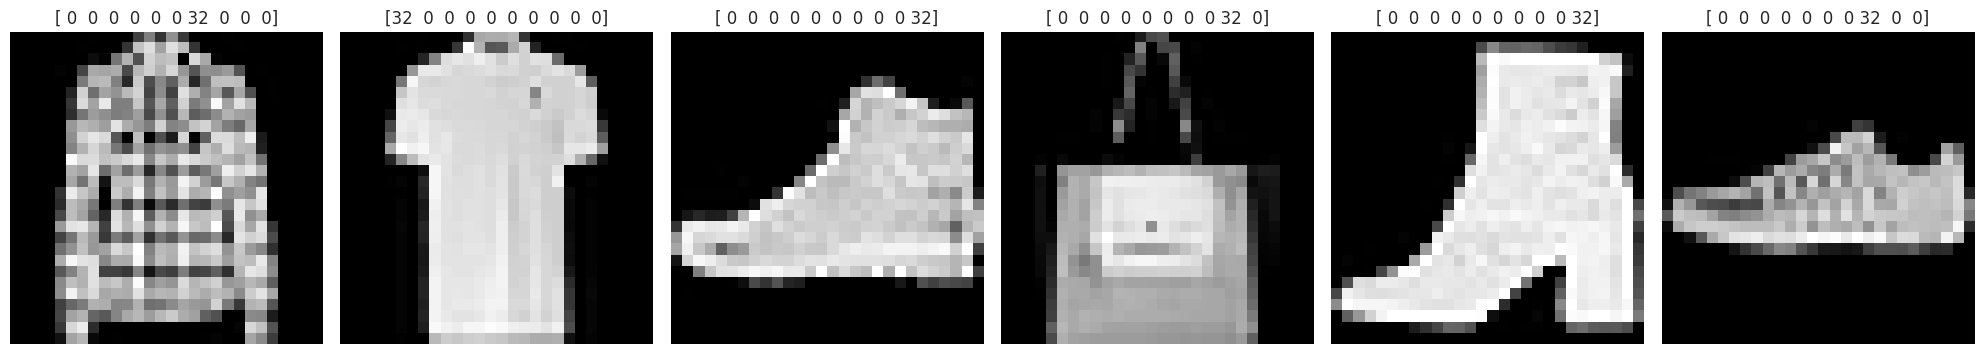

In [9]:
# Show the data and the model
dataset = load_integer_dataset(config, ohe_values=config["ohe_values"], val_dim=0, show_images=True, data_path='../.data')
X_train, _, _, y_train, _, _ = dataset

In [10]:
model = build_CNN(config, X_tr=X_train, y_tr=y_train)
print(model.extra_repr(1))

IntegerLocalLossCNN(
	(0): Sequential(
			(0): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=1, out_channels=128, bias=False, decay_rate_inv=28000)
			(1): ConstantScaling(fwd_factor=2304, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(8, 4), stride=(8, 4), padding=(4, 0))
			(1): Flatten()
			(2): IntegerLinear(in_features=3584, out_features=10, bias=False, decay_rate_inv=3500)
			(3): ConstantScaling(fwd_factor=917504, bwd_factor=1)
		)
	)
			(1): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=128, out_channels=256, bias=False, decay_rate_inv=28000)
			(1): ConstantScaling(fwd_factor=294912, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(8, 8), stride=(8, 8), padding=(4, 4))
			(1): Flatten()
			(2): IntegerLinear(in_features=4096, out_features=10, bias=False, decay_rate_inv=3500)
			(3): ConstantScaling(fwd_factor=104857

In [11]:
def run_experiment(exp_config):
    # Setup reproducibility
    print(f"{'-' * 64}")
    print(f"Running experiment with seed {exp_config['seed']}...")
    np.random.seed(exp_config["seed"])
    cp.random.seed(exp_config["seed"])
    
    # Load the dataset
    data = load_integer_dataset(exp_config, ohe_values=exp_config["ohe_values"], val_dim=0, show_images=False, show_log=False, data_path='../.data')
    X_tr, _, X_test, y_tr, _, y_test = data

    # Setup data augmentation
    augmentation_pipeline = build_augmentation_pipeline(exp_config)

    # Build and train the model
    m = build_CNN(exp_config, X_tr=X_tr, y_tr=y_tr)    
    best_train_acc, best_test_acc = train_test_experiment(
        m, exp_config, X_tr=X_tr, X_te=X_test, y_tr=y_tr, y_te=y_test,
        augmentation_pipeline=augmentation_pipeline,
        show_local_accuracies=False, show_progress_bar=False
    )

    # Append the results to a CSV file
    with open('./results.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([exp_config["seed"], best_train_acc, best_test_acc])
        
    # Save the first model
    if not pathlib.Path('model.pkl').exists():
        with open('model.pkl', 'wb') as f:
            pickle.dump(m, f)

In [12]:
N_EXPERIMENTS = 10
for i in range(N_EXPERIMENTS):
    run_experiment(config)
    config["seed"] += 1

----------------------------------------------------------------
Running experiment with seed 42...
Epoch   1/150 - Train accuracy: 15.063% - Test accuracy: 39.583%


## Aggregated results

In [ ]:
with open('results.csv', mode='r') as file:
    results = np.array(list(csv.reader(file)), dtype=np.float32)

In [ ]:
# Compute mean and standard deviation
mean_train_acc = np.mean(results[:,1])
std_train_acc = np.std(results[:,1])
mean_test_acc = np.mean(results[:,2])
std_test_acc = np.std(results[:,2])

In [ ]:
print("Mean results with 95% confidence interval:")
print(f"- Train accuracy: {mean_train_acc:.2%} ± {std_train_acc * 2:.2%}")
print(f"-  Test accuracy: {mean_test_acc:.2%} ± {std_test_acc * 2:.2%}")